# Preparing the datasets as input

### Merge dataframes to have:
- Feature variables: Time (FZ_AB), Richtung (1/2), Day type (Tage_SA/SO/SA_N/SO_N or weekday) GPS (Latitude/Longitude) and Vehicle_type (Tram, bus, trolleybus, seilbahn, forchbahn, nachtnetz)
- Target variables: Number of passengers (Besetzung) or Occupancy or number of Freeseats.

Tagtype probably will also be nice to include but eventually not included because the remarks from VBZ is not understandable.
Vehicle type, direction (richtung), day type attributes could also be incorporated by running the optional cells.

### Data downloaded from:
https://data.stadt-zuerich.ch/dataset/vbz_fahrgastzahlen_ogd
and
https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd

### This code is modified from: 
https://github.com/Chocobosaurus/uzh-data-science-project/blob/main/src/VBZ_Geospatial_Analysis.ipynb
and
https://github.com/VerkehrsbetriebeZuerich/vbz-flow-concept/blob/master/data-treatment-jupyter/vbz-jupyter.ipynb


In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv

In [2]:
#data directory
datadir = ('data/fahrgastzahlen_2019')

full_data = pd.read_csv(os.path.join(datadir, 'REISENDE.csv'), encoding = "utf-8", sep=';')
full_data.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Besetzung,Distanz,Tage_DTV,Tage_DWV,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt
0,5,18,2,73477,1,14,190,165.0,17:45:30,5,...,83.2,459.0,34.15,34.15,0.0,0.0,0,0,0,19000165
1,5,18,2,73477,1,15,165,166.0,17:47:30,5,...,83.4,186.0,34.15,34.15,0.0,0.0,0,0,0,16500166
2,5,18,2,73477,1,16,166,167.0,17:48:36,5,...,86.4,281.0,34.15,34.15,0.0,0.0,0,0,0,16600167
3,5,18,2,73477,1,17,167,168.0,17:50:30,5,...,87.8,277.0,34.15,34.15,0.0,0.0,0,0,0,16700168
4,5,18,2,73477,1,18,168,216.0,17:52:30,5,...,67.8,250.0,34.15,34.15,0.0,0.0,0,0,0,16800216


In [3]:
# Load the file that contains GPS info and halt_id
haltep = pd.read_csv(os.path.join(datadir, 'haltepunkt.csv'))

# Load the file that contains Halt ID and name: Haltestellen_Id, Haltestellenkurzname
haltest = pd.read_csv(os.path.join(datadir, 'HALTESTELLEN.csv'),encoding = "utf-8", sep=';')

# Load the file that contains Haltestellenkurzname and halt_id
haltest_link = pd.read_csv(os.path.join(datadir, 'haltestelle.csv'),encoding = "utf-8")

# Load the file that contains capacity info = SITZPLAETZE and Plan_Fahrt_Id
# GEFAESSGROESSE.csv not available pre-2020, copied 2020 data to use
capacities = pd.read_csv(os.path.join(datadir, 'GEFAESSGROESSE.csv'), sep=';')

# Load the file that contains Linie_Id and Vehicle type
linie = pd.read_csv(os.path.join(datadir, 'LINIE.csv'), sep = ';')

In [4]:
haltepunkte = haltep.copy()
haltestellen_link = haltest_link.copy()
haltestellen = haltest.copy()

# GPS from 'haltepunkte merged to VBZ 'haltestelle' by halt_id, then haltestelle is merged to 'haltestellen' by haltestellenkurzname
# Use only activ stops, keep only halt_id and GPS,
# then group by id and compute the mean of GPS
haltepunkte = haltepunkte[haltepunkte['halt_punkt_ist_aktiv'] == True]
haltepunkte = haltepunkte.drop(columns=['halt_punkt_ist_aktiv','GPS_Bearing','halt_punkt_id','halt_punkt_diva'])
haltepunkte = haltepunkte.groupby(['halt_id']).mean()[['GPS_Latitude','GPS_Longitude']].reset_index()
haltepunkte['halt_id'].duplicated().sum()
# no duplicated items

0

In [5]:
# Keep only halt_id and halt_kurz
haltestellen_link = haltestellen_link.drop(columns=['halt_diva', 'halt_ist_aktiv', 'halt_lang'])
haltestellen = haltestellen.drop(columns=['Haltestellennummer'])

halttemp = haltestellen_link.merge(haltepunkte, on='halt_id')

stops = halttemp.merge(haltestellen, left_on='halt_kurz', right_on='Haltestellenkurzname')
stops = stops.drop(columns=['halt_kurz', 'halt_id', 'Haltestellenkurzname', 'Haltestellenlangname'])

In [6]:
stops.head()

,GPS_Latitude,GPS_Longitude,Haltestellen_Id
0,47.452271,8.571438,349
1,47.450151,8.563879,348
2,47.294990,8.564286,424
3,47.370167,8.513776,185
4,47.437911,8.562140,346


In [7]:
capacities.head()

,Plan_Fahrt_Id,SITZPLAETZE,KAP_1m2,KAP_2m2,KAP_3m2,KAP_4m2
0,4,26.0,39.5,53.0,66.5,80.0
1,5,26.0,39.5,53.0,66.5,80.0
2,6,26.0,39.5,53.0,66.5,80.0
3,7,26.0,39.5,53.0,66.5,80.0
4,8,26.0,39.5,53.0,66.5,80.0


In [8]:
# Merge capacity data
mergedata=full_data.copy()
data = mergedata.merge(capacities, on = 'Plan_Fahrt_Id')

# Calculate Occupancy and Freeseats values
data['Occupancy'] = data['Besetzung'] / data['SITZPLAETZE']
# Freeseats no longer calculated here but to be restored by SITZPLAETZE * 1-Occupancy
#data['Freeseats'] = data['SITZPLAETZE'] - data['Besetzung']

data.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt,SITZPLAETZE,KAP_1m2,KAP_2m2,KAP_3m2,KAP_4m2,Occupancy
0,3,14,72,4574,1,12,184,235.0,07:58:24,15,...,0,0,0,18400235,96.0,132.0,168.0,204.0,240.0,0.098542
1,3,14,72,4574,1,13,235,236.0,07:59:42,15,...,0,0,0,23500236,96.0,132.0,168.0,204.0,240.0,0.090208
2,3,14,72,4574,1,14,236,237.0,08:01:18,15,...,0,0,0,23600237,96.0,132.0,168.0,204.0,240.0,0.071458
3,3,14,72,4574,1,15,237,238.0,08:02:18,15,...,0,0,0,23700238,96.0,132.0,168.0,204.0,240.0,0.065937
4,3,14,72,4574,1,16,238,239.0,08:03:06,15,...,0,0,0,23800239,96.0,132.0,168.0,204.0,240.0,0.058333


In [9]:
# Fix the 4-28 hour expression to 0-23
def replace_hour(hour_str):
    hour = int(hour_str)
    if hour >= 24:
        return str(hour % 24).zfill(2)  # Wrap the hour back to 0-23 and pad with leading zero if necessary
    else:
        return str(hour).zfill(2)

data['FZ_AB'] = data['FZ_AB'].str.replace(r'^(\d{2})', lambda x: replace_hour(x.group(1)), regex=True)

sorted(data.FZ_AB.str.slice(stop=2).unique())

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

In [10]:
# Convert hours from time_obj to 0.5 hour slots
def time_to_float(time_str):

    time_obj = pd.to_datetime(time_str, format="%H:%M:%S")

    hour = time_obj.hour
    minute = time_obj.minute

    fractional_hours = hour + minute / 60.0
    rounded_hours = round(fractional_hours * 2) / 2  
    return rounded_hours

data['FZ_AB'] = data['FZ_AB'].apply(time_to_float)
data.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt,SITZPLAETZE,KAP_1m2,KAP_2m2,KAP_3m2,KAP_4m2,Occupancy
0,3,14,72,4574,1,12,184,235.0,8.0,15,...,0,0,0,18400235,96.0,132.0,168.0,204.0,240.0,0.098542
1,3,14,72,4574,1,13,235,236.0,8.0,15,...,0,0,0,23500236,96.0,132.0,168.0,204.0,240.0,0.090208
2,3,14,72,4574,1,14,236,237.0,8.0,15,...,0,0,0,23600237,96.0,132.0,168.0,204.0,240.0,0.071458
3,3,14,72,4574,1,15,237,238.0,8.0,15,...,0,0,0,23700238,96.0,132.0,168.0,204.0,240.0,0.065937
4,3,14,72,4574,1,16,238,239.0,8.0,15,...,0,0,0,23800239,96.0,132.0,168.0,204.0,240.0,0.058333


In [11]:
df = data.copy()
sum(df["Haltestellen_Id"].isna())
# No NaN

0

In [12]:
#######################################################################
# Option: 
# Merge vehicle type with df, merge all region bus routes as simply bus
linie = linie.drop(columns = ['Linienname', 'Linienname_Fahrgastauskunft'])
df = df.merge(linie, on = 'Linien_Id')

def assignvehicletype(row):
    val = None
    if row['VSYS'] == 'B' or row['VSYS'] == 'BL' or row['VSYS'] == 'BZ' or row['VSYS'] == 'BP' or row['VSYS'] == 'BG':
        val= 'B'
    else:
        return row['VSYS']            
    return val
    
df['Vehicle_type'] = df.apply(assignvehicletype, axis=1)

In [13]:
df = df.drop(columns=['Linien_Id', 'Linienname',
       'Sequenz', 'Nach_Hst_Id', 'Anzahl_Messungen', 'Einsteiger', 'Aussteiger','Distanz',
       'Tage_DTV', 'Tage_DWV', 'ID_Abschnitt', 'KAP_1m2', 'KAP_2m2',
       'KAP_3m2', 'KAP_4m2', 'VSYS']) # Keep Tagtyp_Id for now

# found NaN with terminal stops
df.dropna(inplace=True)

In [14]:
# Merge GPS from stops with df
df = df.merge(stops, on = 'Haltestellen_Id')
df = df.drop(columns=['Plan_Fahrt_Id', 'Haltestellen_Id'])
# Tagtyp makes sense to use, but cannot read the annot table
df = df.drop(columns=['Tagtyp_Id'])
df.head()

,Richtung,FZ_AB,Besetzung,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,SITZPLAETZE,Occupancy,Vehicle_type,GPS_Latitude,GPS_Longitude
0,1,8.0,9.46,0.0,62.0,0,0,0,96.0,0.098542,TR,47.369997,8.519147
1,1,8.0,10.00,0.0,62.0,0,0,0,32.0,0.312500,TR,47.369997,8.519147
2,1,8.5,12.68,0.0,62.0,0,0,0,48.0,0.264167,TR,47.369997,8.519147
3,1,8.5,14.72,0.0,62.0,0,0,0,32.0,0.460000,TR,47.369997,8.519147
4,1,5.5,6.87,0.0,0.0,0,0,0,48.0,0.143125,TR,47.369997,8.519147


(array([4.87931e+05, 8.48530e+04, 1.74170e+04, 4.21100e+03, 1.01800e+03,
        3.01000e+02, 9.00000e+01, 2.10000e+01, 3.00000e+00, 1.00000e+00]),
 array([0.        , 0.87023077, 1.74046154, 2.61069231, 3.48092308,
        4.35115385, 5.22138462, 6.09161538, 6.96184615, 7.83207692,
        8.70230769]),
 <BarContainer object of 10 artists>)

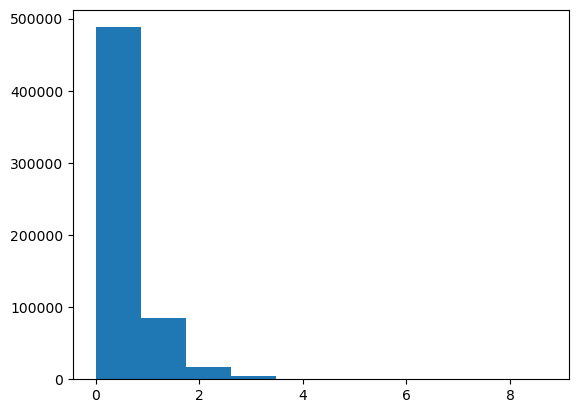

In [15]:
# Check if Occupancy distribution makes sense
plt.hist(df['Occupancy'])

In [16]:
#####################################################################
# Option: 
# Change weekday/weekend attribute to binary values
def assign_binary_value(df, column_name):
    binary_values = []
    for index, row in df.iterrows():
        if row[column_name] != 0:
            binary_values.append(1)
        else:
            binary_values.append(0)
    df[column_name] = binary_values  
    return df

# df = assign_binary_value(df, 'Tage_SA')
# df = assign_binary_value(df, 'Tage_SO')
# df = assign_binary_value(df, 'Tage_SA_N')
# df = assign_binary_value(df, 'Tage_SO_N')
# df.head(20)

In [17]:
#create weekday attribute
def assigndaytype(row):
    if row['Tage_SA'] == 0:
        if row['Tage_SO'] == 0:
            if row['Tage_SA_N'] == 0:
                if row['Tage_SO_N'] == 0:
                    if row['Nachtnetz'] == 0:
                        val=1
                    else:
                        val=0
                else:
                        val=0
            else:
                        val=0
        else:
                        val=0
    else:
                        val=0
    return val
    
df['Weekday'] = df.apply(assigndaytype, axis=1)

In [18]:
# Check if Nachtnetz correspond to Tage_SA_N or Tage_SO_N
def filter_non_zero_values(dataset, column_a, column_b):
    filtered_data = []
    for index, row in dataset.iterrows():
        if row[column_a] != 0 or row[column_b] != 0:
            filtered_data.append(row)
    return pd.DataFrame(filtered_data)

dataset = df  # Your dataset
column_a = 'Tage_SA_N'
column_b = 'Tage_SO_N'
# filtered_data = filter_non_zero_values(dataset, column_a, column_b)
# filtered_data.Nachtnetz.unique()

# So if Tage_SA_N or Tage_SO_N is sampled, Nachtnetz attribute is set to 1
# But if the two above are both 0, sometimes Nachtnetz is also 1 because of weekday night traffic

In [19]:
df.rename(columns={'FZ_AB': 'Time', 'SITZPLAETZE': 'Capacity'}, inplace=True)

In [20]:
#######################################################################
# Optional if include these feature variables: Richtung or Vehicle_type
# One-hot encoding for categorical values
df.info()
df = pd.get_dummies(df, columns=['Vehicle_type'])
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595846 entries, 0 to 595845
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Richtung       595846 non-null  int64  
 1   Time           595846 non-null  float64
 2   Besetzung      595846 non-null  float64
 3   Tage_SA        595846 non-null  float64
 4   Tage_SO        595846 non-null  float64
 5   Nachtnetz      595846 non-null  int64  
 6   Tage_SA_N      595846 non-null  int64  
 7   Tage_SO_N      595846 non-null  int64  
 8   Capacity       595846 non-null  float64
 9   Occupancy      595846 non-null  float64
 10  Vehicle_type   595846 non-null  object 
 11  GPS_Latitude   595846 non-null  float64
 12  GPS_Longitude  595846 non-null  float64
 13  Weekday        595846 non-null  int64  
dtypes: float64(8), int64(5), object(1)
memory usage: 63.6+ MB


,Richtung,Time,Besetzung,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,Capacity,Occupancy,GPS_Latitude,GPS_Longitude,Weekday,Vehicle_type_B,Vehicle_type_FB,Vehicle_type_N,Vehicle_type_SB,Vehicle_type_T,Vehicle_type_TR
0,1,8.0,9.46,0.0,62.0,0,0,0,96.0,0.098542,47.369997,8.519147,0,False,False,False,False,False,True
1,1,8.0,10.00,0.0,62.0,0,0,0,32.0,0.312500,47.369997,8.519147,0,False,False,False,False,False,True
2,1,8.5,12.68,0.0,62.0,0,0,0,48.0,0.264167,47.369997,8.519147,0,False,False,False,False,False,True
3,1,8.5,14.72,0.0,62.0,0,0,0,32.0,0.460000,47.369997,8.519147,0,False,False,False,False,False,True
4,1,5.5,6.87,0.0,0.0,0,0,0,48.0,0.143125,47.369997,8.519147,1,False,False,False,False,False,True
5,1,5.5,12.77,0.0,0.0,0,0,0,90.0,0.141889,47.369997,8.519147,1,False,False,False,False,False,True
6,1,6.5,6.54,0.0,0.0,0,0,0,60.0,0.109000,47.369997,8.519147,1,False,False,False,False,False,True
7,2,5.5,10.06,0.0,0.0,0,0,0,90.0,0.111778,47.369997,8.519147,1,False,False,False,False,False,True
8,2,6.0,8.55,0.0,0.0,0,0,0,48.0,0.178125,47.369997,8.519147,1,False,False,False,False,False,True
9,2,6.0,7.75,0.0,0.0,0,0,0,90.0,0.086111,47.369997,8.519147,1,False,False,False,False,False,True


In [21]:
# Drop more attributes to shrink the data
df = df.drop(columns=['Richtung', 'Tage_SA', 'Besetzung', 'Tage_SA', 'Tage_SO', 'Tage_SA_N', 'Tage_SO_N'])
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595846 entries, 0 to 595845
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             595846 non-null  float64
 1   Nachtnetz        595846 non-null  int64  
 2   Capacity         595846 non-null  float64
 3   Occupancy        595846 non-null  float64
 4   GPS_Latitude     595846 non-null  float64
 5   GPS_Longitude    595846 non-null  float64
 6   Weekday          595846 non-null  int64  
 7   Vehicle_type_B   595846 non-null  bool   
 8   Vehicle_type_FB  595846 non-null  bool   
 9   Vehicle_type_N   595846 non-null  bool   
 10  Vehicle_type_SB  595846 non-null  bool   
 11  Vehicle_type_T   595846 non-null  bool   
 12  Vehicle_type_TR  595846 non-null  bool   
dtypes: bool(6), float64(5), int64(2)
memory usage: 35.2 MB


,Time,Nachtnetz,Capacity,Occupancy,GPS_Latitude,GPS_Longitude,Weekday,Vehicle_type_B,Vehicle_type_FB,Vehicle_type_N,Vehicle_type_SB,Vehicle_type_T,Vehicle_type_TR
0,8.0,0,96.0,0.098542,47.369997,8.519147,0,False,False,False,False,False,True
1,8.0,0,32.0,0.312500,47.369997,8.519147,0,False,False,False,False,False,True
2,8.5,0,48.0,0.264167,47.369997,8.519147,0,False,False,False,False,False,True
3,8.5,0,32.0,0.460000,47.369997,8.519147,0,False,False,False,False,False,True
4,5.5,0,48.0,0.143125,47.369997,8.519147,1,False,False,False,False,False,True
5,5.5,0,90.0,0.141889,47.369997,8.519147,1,False,False,False,False,False,True
6,6.5,0,60.0,0.109000,47.369997,8.519147,1,False,False,False,False,False,True
7,5.5,0,90.0,0.111778,47.369997,8.519147,1,False,False,False,False,False,True
8,6.0,0,48.0,0.178125,47.369997,8.519147,1,False,False,False,False,False,True
9,6.0,0,90.0,0.086111,47.369997,8.519147,1,False,False,False,False,False,True


In [22]:
df.to_csv(os.path.join(datadir, 'cleaned.csv'), index=False)